In [1]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np

import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.photUtils as photUtils

In [2]:
opsdb = db.OpsimDatabase('enigma_1189_sqlite.db')
outDir = 'output_directory'
resultsDb = db.ResultsDb(outDir=outDir)

In [15]:
# Delete the metric from the registry if it already exists; we want to redefine it.
try:
    del metrics.BaseMetric.registry['__main__.StarGalaxySeparationMetric']
except KeyError:
    pass

class StarGalaxySeparationMetric(metrics.BaseMetric):
    """Calculate Star/Galaxy separation, in some quantification."""
    
    def __init__(self, target_mag=None, metricName='StarGalaxySeparation', **kwargs):
        """Instantiate some of the other metrics that we call."""
        
        assert target_mag is not None
        self.target_mag = target_mag
        
        self.m5_metric = metrics.Coaddm5Metric(metricName="__coaddm5")
        col = ['finSeeing', 'fiveSigmaDepth']
        super(StarGalaxySeparationMetric, self).__init__(col=col, metricName=metricName,
                                                         **kwargs)
        
    def SNR_from_m5(self, m5, mag, gamma=0.038):
        fluxRatio = 10**(-0.4*(m5 - mag))
        noiseSq = (0.04-gamma)*fluxRatio + gamma*fluxRatio**2
        return 1/np.sqrt(noiseSq)
    
    def contamination_frac(self, alpha_psf, alpha_g, SNR):
        """This will interpolate across the psf and galaxy sizs and SNR to produce
        a contamination fraction. Right now we just return SNR."""
        return SNR
    
    def median_psf(self, dataSlice, slicePoint=None):
        return np.median(dataSlice['finSeeing'])        
        
    def run(self, dataSlice, slicePoint=None):
        
        coadd_m5_depth = self.m5_metric.run(dataSlice, slicePoint=slicePoint)
        SNR = self.SNR_from_m5(coadd_m5_depth, self.target_mag)
        alpha_psf = self.median_psf(dataSlice, slicePoint=slicePoint)
        
        contam = self.contamination_frac(alpha_psf, 1.0, SNR)
        
        return contam

In [16]:
metric1 = StarGalaxySeparationMetric(target_mag=24.0)
metric2 = metrics.Coaddm5Metric()
#metric2 = metrics.MedianMetric("finSeeing")

slicer1 = slicers.HealpixSlicer(nside=64)
sqlconstraint= 'filter = "r"'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
snr_bundle = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)
m5_bundle = metricBundles.MetricBundle(metric2, slicer1, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [17]:
bundleDict = {'SNR_24':snr_bundle, 'M5': m5_bundle}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Querying database with constraint filter = "r"
Found 544710 visits
Running:  ['M5', 'SNR_24']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter = "r" sqlconstraint now.
monopole: 27.1379  dipole: lon: 84.5111, lat: 29.0736, amp: 0.053101
monopole: 68.8455  dipole: lon: 82.5002, lat: -63.3391, amp: 3.04823
Plotting complete.


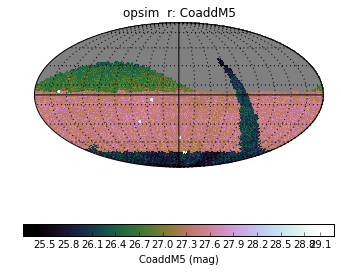

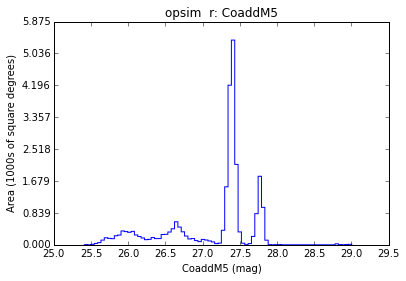

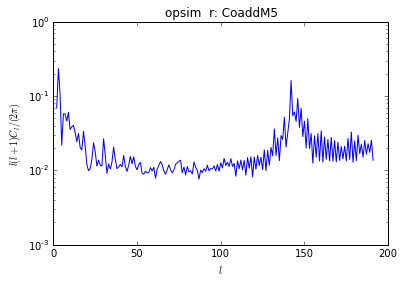

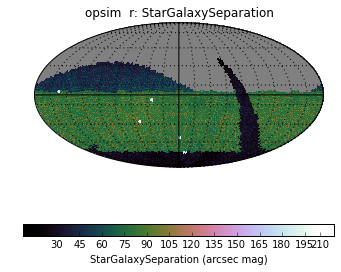

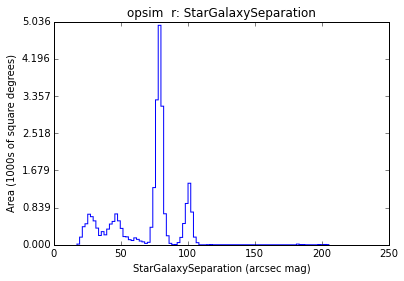

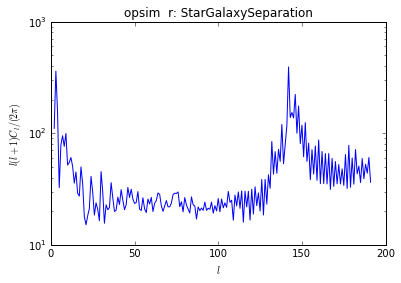

In [18]:
group.plotAll(closefigs=False, )